In [1]:
import pandas as pd
df=pd.read_csv('aggregated_all.csv')
import pandas as pd

# Assuming your DataFrame is named df
#df = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with your actual dataset file

# List of columns to drop
columns_to_drop = ['superhost_period_all', 'prev_host_is_superhost_in_period', 'superhost_change_lose_superhost',
                   'prev_Instantbook Enabled', 'tract_total_pop', 'tract_white_perc', 'tract_black_perc',
                   'tract_asian_perc', 'tract_housing_units', 'zip_total_population',
                   'zip_hispanic_or_latino_anyrace', 'zip_hispanic_or_latino_anyrace_percent', 'zip_white_nothispanic',
                   'zip_white_nothispanic_percent', 'zip_black_nothispanic', 'zip_black_nothispanic_percent',
                   'zip_asian_nothispanic', 'zip_asian_nothispanic_percent', 'prev_year_superhosts',
                   'booked_days_period_city', 'revenue_period_city', 'Check']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

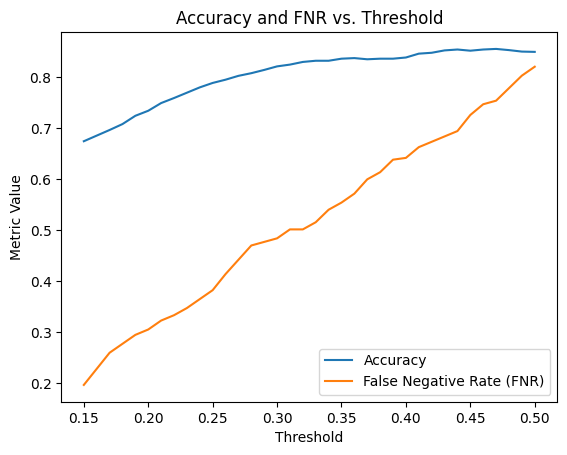

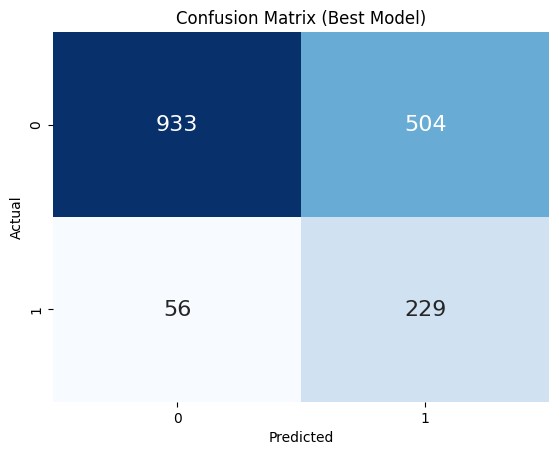

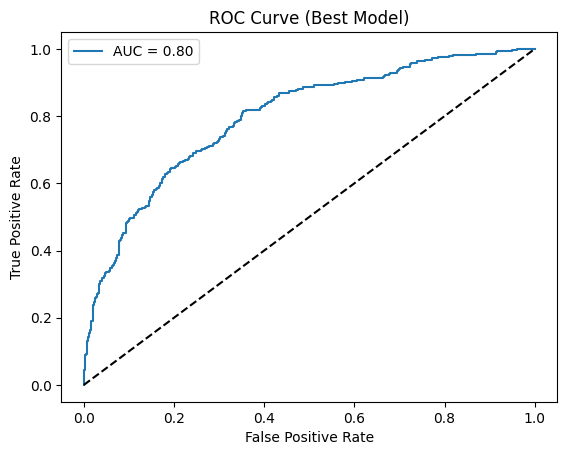

Best Threshold: 0.1500
Accuracy: 0.8502
Misclassification Rate: 0.1498
True Positive Rate (Recall): 0.8035
False Positive Rate: 0.3507
True Negative Rate: 0.6493
Precision: 0.3124
Recall: 0.8035
AUC: 0.7976


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
#df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Generate thresholds from 0.15 to 0.5
thresholds = [i / 100.0 for i in range(15, 51)]

# Initialize variables to store results
accuracy_list = []
fnr_list = []

# Iterate over thresholds
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    fnr_list.append(fnr)
    accuracy_list.append(accuracy)

# Plot Accuracy vs. FNR
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, fnr_list, label='False Negative Rate (FNR)')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()
plt.show()

# Find the threshold that minimizes FNR
best_threshold = thresholds[fnr_list.index(min(fnr_list))]

# Adjust the probability threshold to the best threshold
y_pred_best = (y_prob > best_threshold).astype(int)

# Draw colorful confusion matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Plot ROC curve for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_prob)
plt.plot(fpr_best, tpr_best, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend()
plt.show()

# Calculate additional metrics for the best model
tn_best, fp_best, fn_best, tp_best = cm_best.ravel()
tnr_best = tn_best / (tn_best + fp_best)  # True Negative Rate / Specificity
precision_best = tp_best / (tp_best + fp_best)  # Precision / Positive Predictive Value
recall_best = tp_best / (tp_best + fn_best)  # Recall / Sensitivity / True Positive Rate
misclassification_rate_best = 1 - accuracy
fpr_best = fp_best / (fp_best + tn_best)  # False Positive Rate

# Print additional metrics for the best model
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate_best:.4f}')
print(f'True Positive Rate (Recall): {recall_best:.4f}')
print(f'False Positive Rate: {fpr_best:.4f}')
print(f'True Negative Rate: {tnr_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


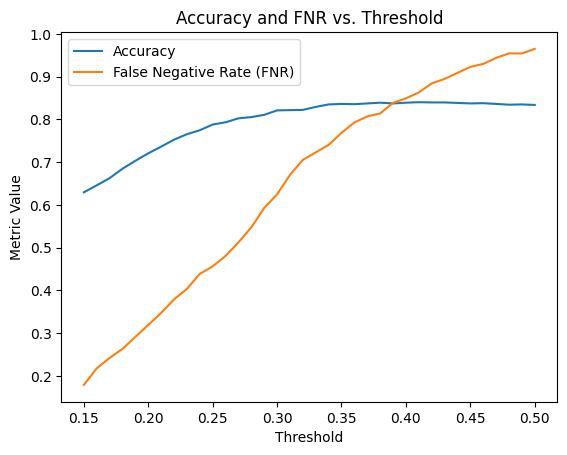

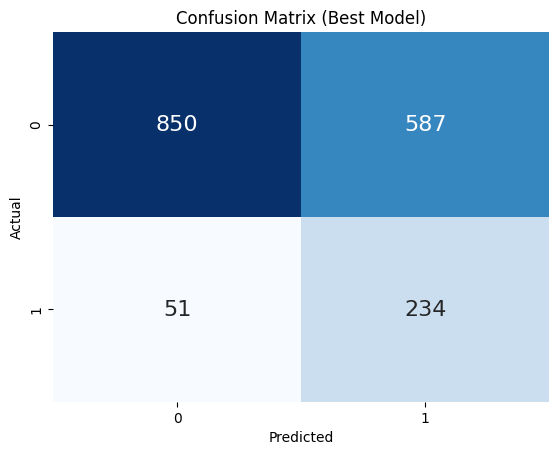

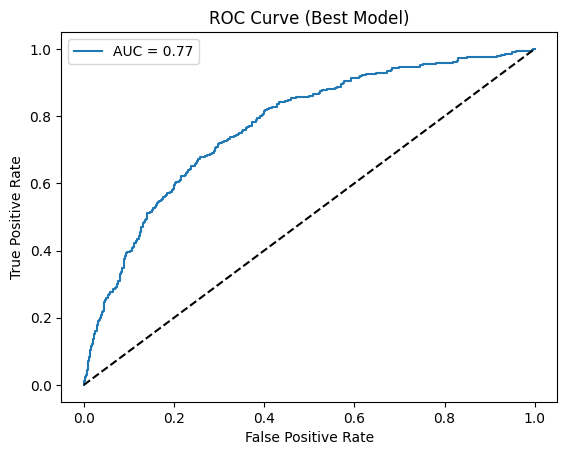

Best Threshold: 0.1500
Accuracy: 0.8339
Misclassification Rate: 0.1661
True Positive Rate (Recall): 0.8211
False Positive Rate: 0.4085
True Negative Rate: 0.5915
Precision: 0.2850
Recall: 0.8211
AUC: 0.7711


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
#df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Logistic Regression model
model = LogisticRegression(random_state=42)

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = LogisticRegression(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Generate thresholds from 0.15 to 0.5
thresholds = [i / 100.0 for i in range(15, 51)]

# Initialize variables to store results
accuracy_list = []
fnr_list = []

# Iterate over thresholds
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    fnr_list.append(fnr)
    accuracy_list.append(accuracy)

# Plot Accuracy vs. FNR
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, fnr_list, label='TPR)')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()
plt.show()

# Find the threshold that minimizes FNR
best_threshold = thresholds[fnr_list.index(min(fnr_list))]

# Adjust the probability threshold to the best threshold
y_pred_best = (y_prob > best_threshold).astype(int)

# Draw colorful confusion matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Plot ROC curve for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_prob)
plt.plot(fpr_best, tpr_best, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend()
plt.show()

# Calculate additional metrics for the best model
tn_best, fp_best, fn_best, tp_best = cm_best.ravel()
tnr_best = tn_best / (tn_best + fp_best)  # True Negative Rate / Specificity
precision_best = tp_best / (tp_best + fp_best)  # Precision / Positive Predictive Value
recall_best = tp_best / (tp_best + fn_best)  # Recall / Sensitivity / True Positive Rate
misclassification_rate_best = 1 - accuracy
fpr_best = fp_best / (fp_best + tn_best)  # False Positive Rate

# Print additional metrics for the best model
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate_best:.4f}')
print(f'True Positive Rate (Recall): {recall_best:.4f}')
print(f'False Positive Rate: {fpr_best:.4f}')
print(f'True Negative Rate: {tnr_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.386735
         Iterations 8
                                Logit Regression Results                               
Dep. Variable:     host_is_superhost_in_period   No. Observations:                 6886
Model:                                   Logit   Df Residuals:                     6847
Method:                                    MLE   Df Model:                           38
Date:                         Sat, 09 Dec 2023   Pseudo R-squ.:                  0.1373
Time:                                 02:14:21   Log-Likelihood:                -2663.1
converged:                                True   LL-Null:                       -3087.0
Covariance Type:                     nonrobust   LLR p-value:                2.552e-153
                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

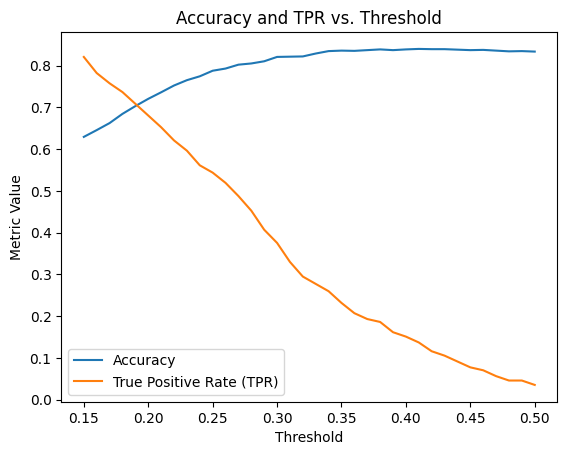

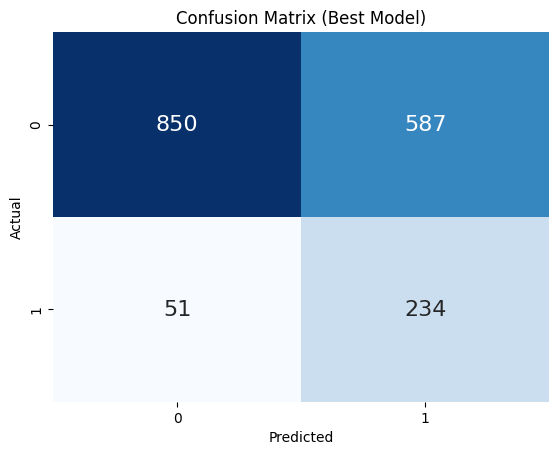

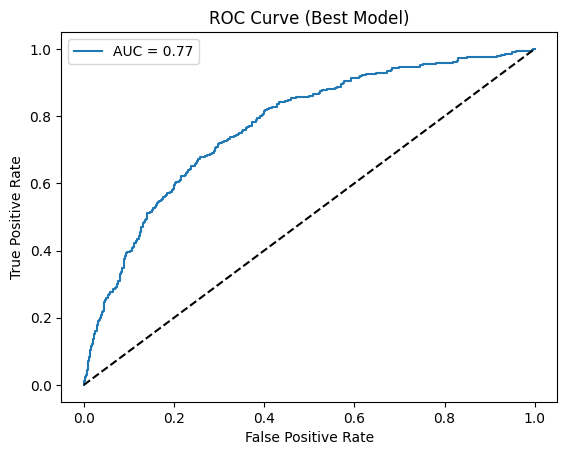

Best Threshold: 0.1500
Accuracy: 0.8339
Misclassification Rate: 0.1661
True Positive Rate (Recall): 0.8211
False Positive Rate: 0.4085
True Negative Rate: 0.5915
Precision: 0.2850
Recall: 0.8211
AUC: 0.7711


In [14]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
#df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Logistic Regression model
model = LogisticRegression(random_state=42)

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = LogisticRegression(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Obtain regression results
X_train_sm = sm.add_constant(X_train)  # Add a constant term to the features
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Print the regression results
print(result.summary())

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Generate thresholds from 0.15 to 0.5
thresholds = [i / 100.0 for i in range(15, 51)]

# Initialize variables to store results
accuracy_list = []
tpr_list = []

# Iterate over thresholds
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # True Positive Rate
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    tpr_list.append(tpr)
    accuracy_list.append(accuracy)

# Plot Accuracy and TPR vs. Threshold
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, tpr_list, label='True Positive Rate (TPR)')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and TPR vs. Threshold')
plt.legend()
plt.show()

# Find the threshold that maximizes TPR
best_threshold = thresholds[tpr_list.index(max(tpr_list))]

# Adjust the probability threshold to the best threshold
y_pred_best = (y_prob > best_threshold).astype(int)

# Draw colorful confusion matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Plot ROC curve for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_prob)
plt.plot(fpr_best, tpr_best, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend()
plt.show()

# Calculate additional metrics for the best model
tn_best, fp_best, fn_best, tp_best = cm_best.ravel()
tnr_best = tn_best / (tn_best + fp_best)  # True Negative Rate / Specificity
precision_best = tp_best / (tp_best + fp_best)  # Precision / Positive Predictive Value
recall_best = tp_best / (tp_best + fn_best)  # Recall / Sensitivity / True Positive Rate
misclassification_rate_best = 1 - accuracy
fpr_best = fp_best / (fp_best + tn_best)  # False Positive Rate

# Print additional metrics for the best model
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate_best:.4f}')
print(f'True Positive Rate (Recall): {recall_best:.4f}')
print(f'False Positive Rate: {fpr_best:.4f}')
print(f'True Negative Rate: {tnr_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


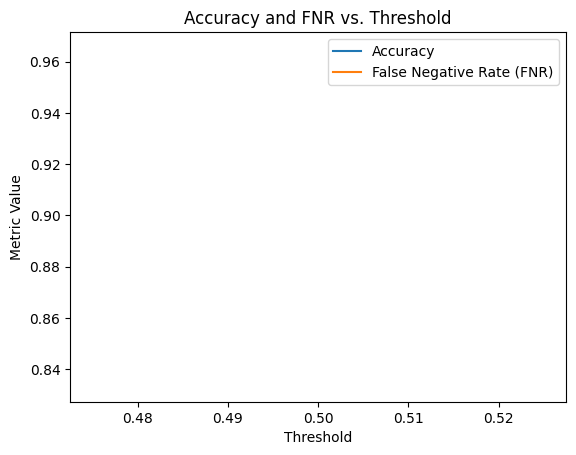

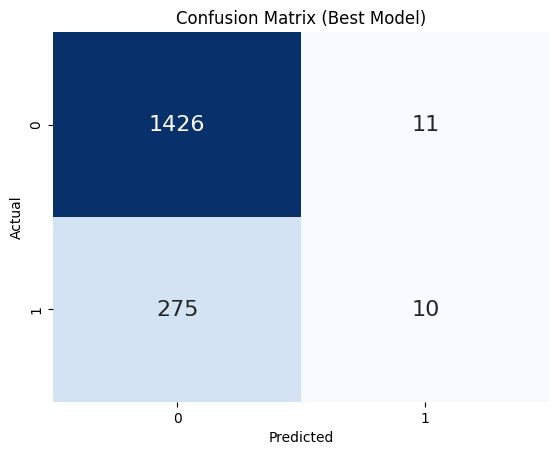

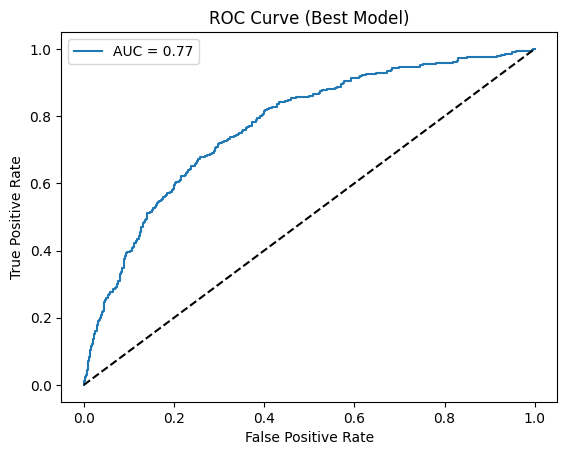

Best Threshold: 0.5000
Accuracy: 0.8339
Misclassification Rate: 0.1661
True Positive Rate (Recall): 0.0351
False Positive Rate: 0.0077
True Negative Rate: 0.9923
Precision: 0.4762
Recall: 0.0351
AUC: 0.7711


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
#df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Logistic Regression model
model = LogisticRegression(random_state=42)

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = LogisticRegression(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Generate thresholds from 0.15 to 0.5
thresholds = [0.5]

# Initialize variables to store results
accuracy_list = []
fnr_list = []

# Iterate over thresholds
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    fnr_list.append(fnr)
    accuracy_list.append(accuracy)

# Plot Accuracy vs. FNR
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, fnr_list, label='False Negative Rate (FNR)')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()
plt.show()

# Find the threshold that minimizes FNR
best_threshold = thresholds[fnr_list.index(min(fnr_list))]

# Adjust the probability threshold to the best threshold
y_pred_best = (y_prob > best_threshold).astype(int)

# Draw colorful confusion matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Plot ROC curve for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_prob)
plt.plot(fpr_best, tpr_best, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend()
plt.show()

# Calculate additional metrics for the best model
tn_best, fp_best, fn_best, tp_best = cm_best.ravel()
tnr_best = tn_best / (tn_best + fp_best)  # True Negative Rate / Specificity
precision_best = tp_best / (tp_best + fp_best)  # Precision / Positive Predictive Value
recall_best = tp_best / (tp_best + fn_best)  # Recall / Sensitivity / True Positive Rate
misclassification_rate_best = 1 - accuracy
fpr_best = fp_best / (fp_best + tn_best)  # False Positive Rate

# Print additional metrics for the best model
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate_best:.4f}')
print(f'True Positive Rate (Recall): {recall_best:.4f}')
print(f'False Positive Rate: {fpr_best:.4f}')
print(f'True Negative Rate: {tnr_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.386735
         Iterations 8
                                Logit Regression Results                               
Dep. Variable:     host_is_superhost_in_period   No. Observations:                 6886
Model:                                   Logit   Df Residuals:                     6847
Method:                                    MLE   Df Model:                           38
Date:                         Sat, 09 Dec 2023   Pseudo R-squ.:                  0.1373
Time:                                 01:11:48   Log-Likelihood:                -2663.1
converged:                                True   LL-Null:                       -3087.0
Covariance Type:                     nonrobust   LLR p-value:                2.552e-153
                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

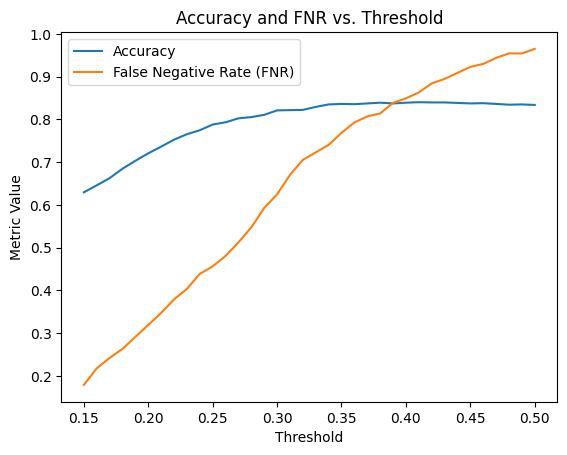

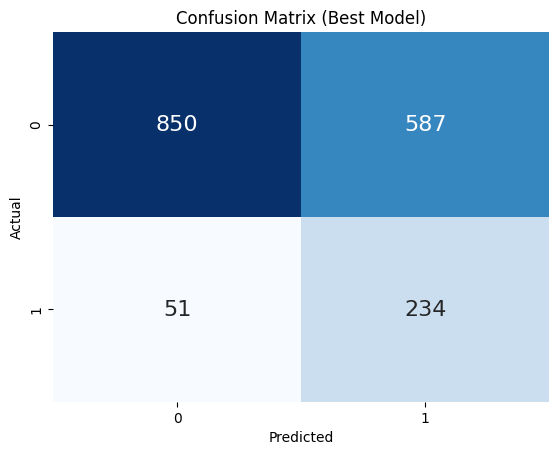

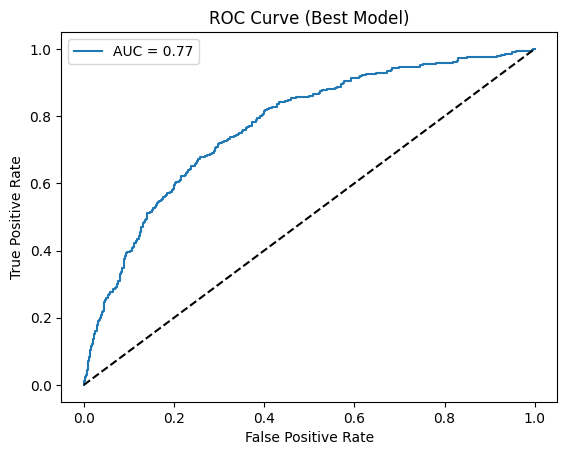

Best Threshold: 0.1500
Accuracy: 0.8339
Misclassification Rate: 0.1661
True Positive Rate (Recall): 0.8211
False Positive Rate: 0.4085
True Negative Rate: 0.5915
Precision: 0.2850
Recall: 0.8211
AUC: 0.7711


In [9]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
#df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Logistic Regression model
model = LogisticRegression(random_state=42)

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = LogisticRegression(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Obtain regression results
X_train_sm = sm.add_constant(X_train)  # Add a constant term to the features
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Print the regression results
print(result.summary())

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Generate thresholds from 0.15 to 0.5
thresholds = [i / 100.0 for i in range(15, 51)]

# Initialize variables to store results
accuracy_list = []
fnr_list = []

# Iterate over thresholds
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    fnr_list.append(fnr)
    accuracy_list.append(accuracy)

# Plot Accuracy vs. FNR
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, fnr_list, label='False Negative Rate (FNR)')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()
plt.show()

# Find the threshold that minimizes FNR
best_threshold = thresholds[fnr_list.index(min(fnr_list))]

# Adjust the probability threshold to the best threshold
y_pred_best = (y_prob > best_threshold).astype(int)

# Draw colorful confusion matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Plot ROC curve for the best model
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_prob)
plt.plot(fpr_best, tpr_best, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend()
plt.show()

# Calculate additional metrics for the best model
tn_best, fp_best, fn_best, tp_best = cm_best.ravel()
tnr_best = tn_best / (tn_best + fp_best)  # True Negative Rate / Specificity
precision_best = tp_best / (tp_best + fp_best)  # Precision / Positive Predictive Value
recall_best = tp_best / (tp_best + fn_best)  # Recall / Sensitivity / True Positive Rate
misclassification_rate_best = 1 - accuracy
fpr_best = fp_best / (fp_best + tn_best)  # False Positive Rate

# Print additional metrics for the best model
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate_best:.4f}')
print(f'True Positive Rate (Recall): {recall_best:.4f}')
print(f'False Positive Rate: {fpr_best:.4f}')
print(f'True Negative Rate: {tnr_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')

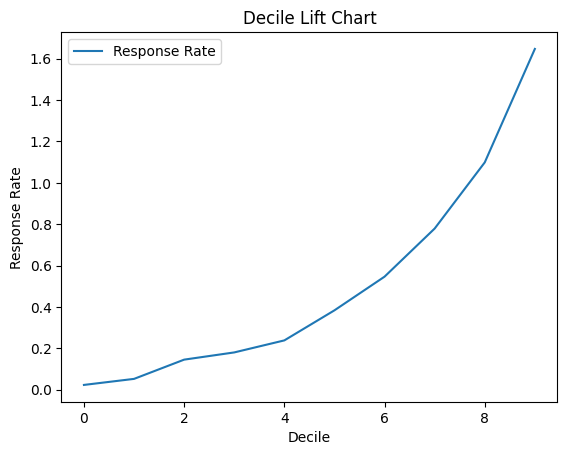

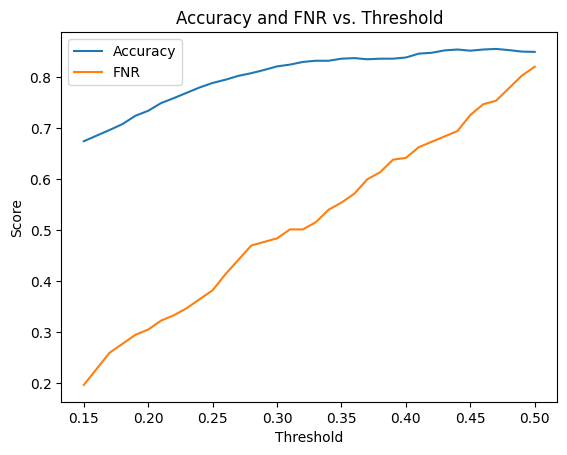

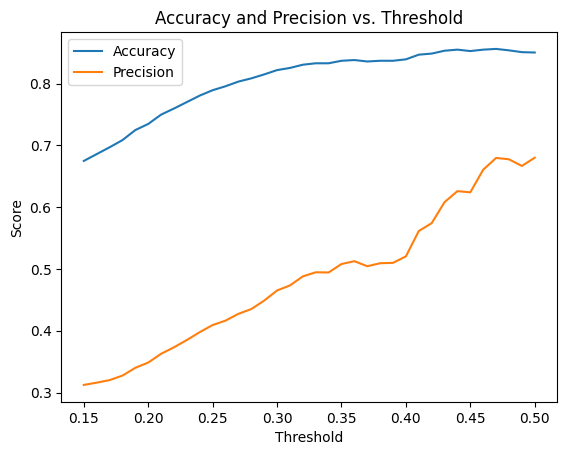

Text(0.5, 1.0, 'Confusion Matrix (Optimal Threshold)')

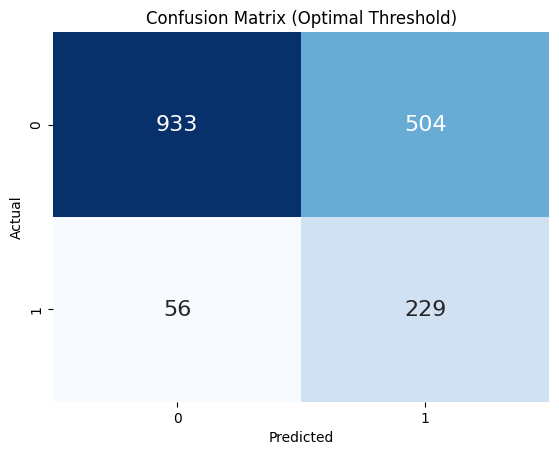

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
# df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Find the optimal threshold
threshold_range = np.arange(0.15, 0.51, 0.01)
accuracy_list = []
fnr_list = []
precision_list = []

for threshold in threshold_range:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])  # Precision

    accuracy_list.append(accuracy)
    fnr_list.append(fnr)
    precision_list.append(precision)

# Find the optimal threshold based on the specified criteria
best_threshold_index = np.argmax(np.array(accuracy_list) - np.array(fnr_list))
optimal_threshold = threshold_range[best_threshold_index]

# Update predictions with the optimal threshold
y_pred_optimal = (y_prob > optimal_threshold).astype(int)

# Create a decile lift chart
df_test = X_test.copy()
df_test['Airbnb Host ID'] = df.loc[X_test.index, 'Airbnb Host ID']
df_test['Actual'] = y_test
df_test['Predicted_Prob'] = y_prob
df_test['Predicted_Class'] = y_pred_optimal
df_test['Decile'] = pd.qcut(df_test['Predicted_Prob'], q=10, labels=False)

# Calculate actual and expected response rates in each decile
decile_chart = df_test.groupby('Decile').agg({
    'Actual': 'sum',
    'Predicted_Prob': 'mean',
    'Predicted_Class': 'count'
}).reset_index()

# Calculate total responses and response rate for each decile
decile_chart['Total_Responses'] = decile_chart['Actual'].cumsum()
decile_chart['Response_Rate'] = decile_chart['Total_Responses'] / decile_chart['Predicted_Class']

# Sort deciles by predicted response rate
decile_chart = decile_chart.sort_values(by='Predicted_Prob', ascending=False)

# Plot decile lift chart
plt.plot(decile_chart['Decile'], decile_chart['Response_Rate'], label='Response Rate')
plt.xlabel('Decile')
plt.ylabel('Response Rate')
plt.title('Decile Lift Chart')
plt.legend()
plt.show()

# Plot Accuracy vs. FNR
plt.plot(threshold_range, accuracy_list, label='Accuracy')
plt.plot(threshold_range, fnr_list, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()
plt.show()

# Plot Accuracy vs. Precision
plt.plot(threshold_range, accuracy_list, label='Accuracy')
plt.plot(threshold_range, precision_list, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and Precision vs. Threshold')
plt.legend()
plt.show()

# Draw colorful confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Optimal Threshold)')

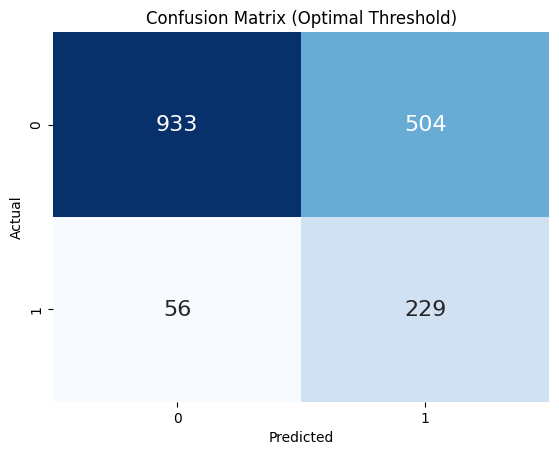

Optimal Threshold: 0.1500
Accuracy: 0.6748
False Negative Rate (FNR): 0.1965
True Positive Rate (TPR): 0.8035
True Negative Rate (TNR): 0.6493
False Positive Rate (FPR): 0.3507
Misclassification Rate: 0.3252
AUC: 0.7976


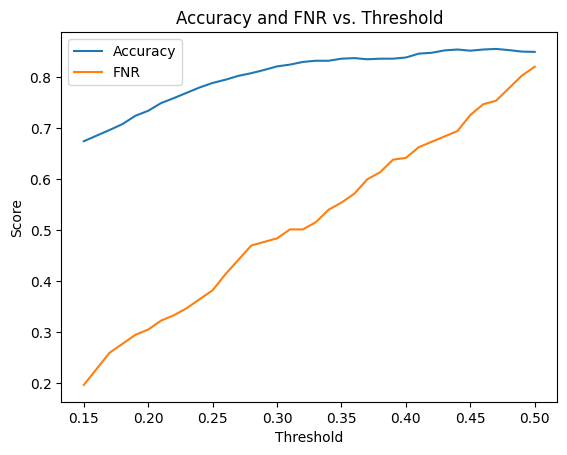

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
#df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Find the optimal threshold
threshold_range = np.arange(0.15, 0.51, 0.01)
accuracy_list = []
fnr_list = []
precision_list = []

for threshold in threshold_range:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    precision = precision_score(y_test, y_pred)  # Precision

    accuracy_list.append(accuracy)
    fnr_list.append(fnr)
    precision_list.append(precision)

# Find the optimal threshold based on the specified criteria
best_threshold_index = np.argmax(np.array(accuracy_list) - np.array(fnr_list))
optimal_threshold = threshold_range[best_threshold_index]

# Update predictions with the optimal threshold
y_pred_optimal = (y_prob > optimal_threshold).astype(int)

# Draw colorful confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Optimal Threshold)')
plt.show()

# Calculate and print other evaluation metrics for the best model
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
fnr_optimal = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])  # False Negative Rate
tpr_optimal = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # True Positive Rate
tnr_optimal = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # True Negative Rate
fpr_optimal = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # False Positive Rate
misclassification_rate_optimal = 1 - accuracy_optimal
roc_auc_optimal = roc_auc_score(y_test, y_prob)

print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'Accuracy: {accuracy_optimal:.4f}')
print(f'False Negative Rate (FNR): {fnr_optimal:.4f}')
print(f'True Positive Rate (TPR): {tpr_optimal:.4f}')
print(f'True Negative Rate (TNR): {tnr_optimal:.4f}')
print(f'False Positive Rate (FPR): {fpr_optimal:.4f}')
print(f'Misclassification Rate: {misclassification_rate_optimal:.4f}')
print(f'AUC: {roc_auc_optimal:.4f}')

# Plot Accuracy vs. FNR
plt.plot(threshold_range, accuracy_list, label='Accuracy')
plt.plot(threshold_range, fnr_list, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()
plt.show()


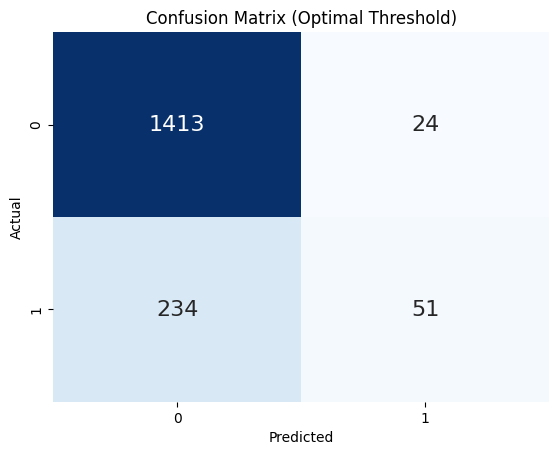

Optimal Threshold: 0.5000
Accuracy: 0.8502
False Negative Rate (FNR): 0.8211
True Positive Rate (TPR): 0.1789
True Negative Rate (TNR): 0.9833
False Positive Rate (FPR): 0.0167
Misclassification Rate: 0.1498
AUC: 0.7976


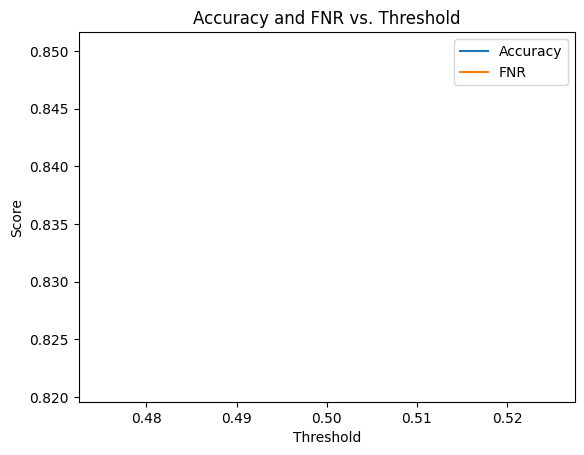

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
#df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Find the optimal threshold
threshold_range = [0.5]
accuracy_list = []
fnr_list = []
precision_list = []

for threshold in threshold_range:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])  # False Negative Rate
    precision = precision_score(y_test, y_pred)  # Precision

    accuracy_list.append(accuracy)
    fnr_list.append(fnr)
    precision_list.append(precision)

# Find the optimal threshold based on the specified criteria
best_threshold_index = np.argmax(np.array(accuracy_list) - np.array(fnr_list))
optimal_threshold = threshold_range[best_threshold_index]

# Update predictions with the optimal threshold
y_pred_optimal = (y_prob > optimal_threshold).astype(int)

# Draw colorful confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Optimal Threshold)')
plt.show()

# Calculate and print other evaluation metrics for the best model
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
fnr_optimal = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])  # False Negative Rate
tpr_optimal = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # True Positive Rate
tnr_optimal = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # True Negative Rate
fpr_optimal = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # False Positive Rate
misclassification_rate_optimal = 1 - accuracy_optimal
roc_auc_optimal = roc_auc_score(y_test, y_prob)

print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'Accuracy: {accuracy_optimal:.4f}')
print(f'False Negative Rate (FNR): {fnr_optimal:.4f}')
print(f'True Positive Rate (TPR): {tpr_optimal:.4f}')
print(f'True Negative Rate (TNR): {tnr_optimal:.4f}')
print(f'False Positive Rate (FPR): {fpr_optimal:.4f}')
print(f'Misclassification Rate: {misclassification_rate_optimal:.4f}')
print(f'AUC: {roc_auc_optimal:.4f}')

# Plot Accuracy vs. FNR
plt.plot(threshold_range, accuracy_list, label='Accuracy')
plt.plot(threshold_range, fnr_list, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()
plt.show()


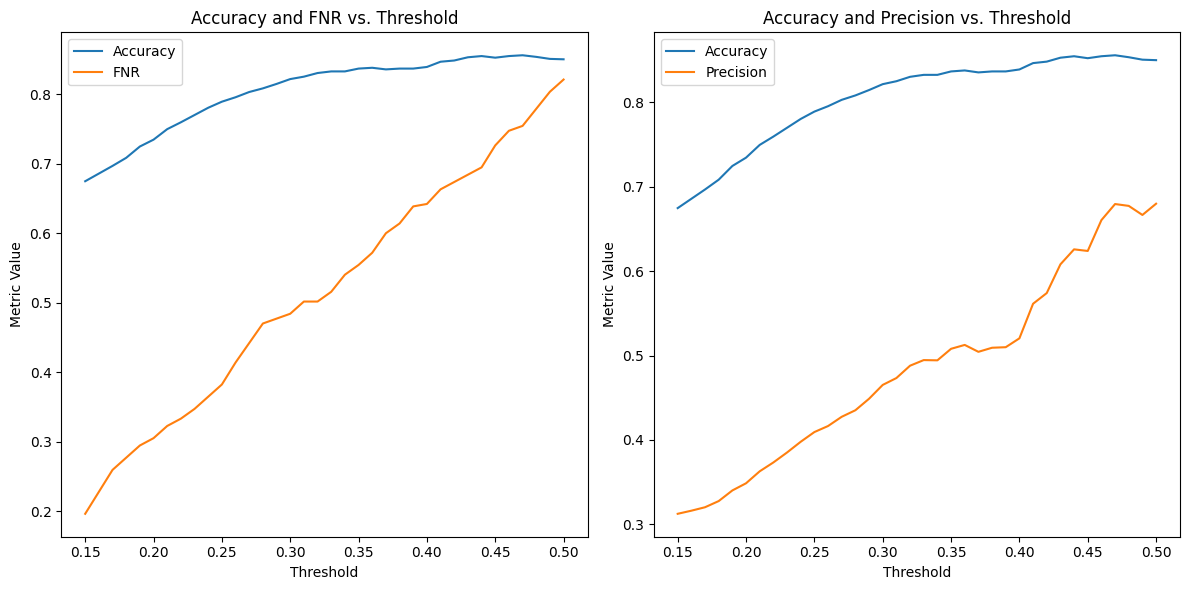

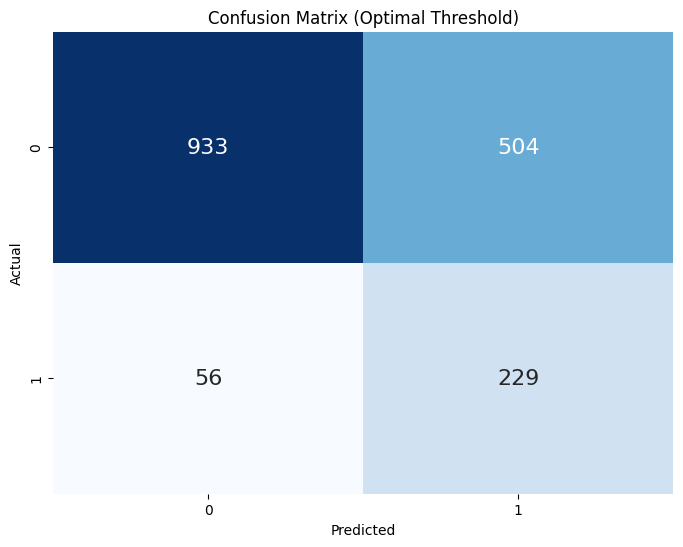

Optimal Threshold: 0.15
Accuracy: 0.6748
Misclassification Rate: 0.3252
True Positive Rate (Recall): 0.8035
False Positive Rate: 0.3507
False Negative Rate: 0.1965
True Negative Rate: 0.6493
Precision: 0.3124
Recall: 0.8035
AUC: 0.7976
Optimal Grid Search Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
# df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 25, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 4, 6]
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Initialize lists to store metrics at different thresholds
thresholds = [i / 100 for i in range(15, 51)]
accuracies = []
fnrs = []
precisions = []

# Loop through different thresholds
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate metrics
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

    # Append to lists
    accuracies.append(accuracy)
    fnrs.append(fnr)
    precisions.append(precision)

# Plot graphs
plt.figure(figsize=(12, 6))

# Accuracy and FNR graph
plt.subplot(1, 2, 1)
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, fnrs, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()

# Accuracy and Precision graph
plt.subplot(1, 2, 2)
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and Precision vs. Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Get the optimal threshold
optimal_threshold_index = fnrs.index(min(fnrs))
optimal_threshold = thresholds[optimal_threshold_index]

# Adjust the probability threshold to the optimal value
y_pred_optimal = (y_prob > optimal_threshold).astype(int)

# Draw colorful confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Optimal Threshold)')
plt.show()

# Print metrics for the best model
print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'Accuracy: {accuracies[optimal_threshold_index]:.4f}')
print(f'Misclassification Rate: {1 - accuracies[optimal_threshold_index]:.4f}')
print(f'True Positive Rate (Recall): {1 - fnrs[optimal_threshold_index]:.4f}')
print(f'False Positive Rate: {cm[0, 1] / (cm[0, 0] + cm[0, 1]):.4f}')
print(f'False Negative Rate: {fnrs[optimal_threshold_index]:.4f}')
print(f'True Negative Rate: {cm[0, 0] / (cm[0, 0] + cm[0, 1]):.4f}')
print(f'Precision: {precisions[optimal_threshold_index]:.4f}')
print(f'Recall: {1 - fnrs[optimal_threshold_index]:.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')
print(f'Optimal Grid Search Parameters: {best_params}')

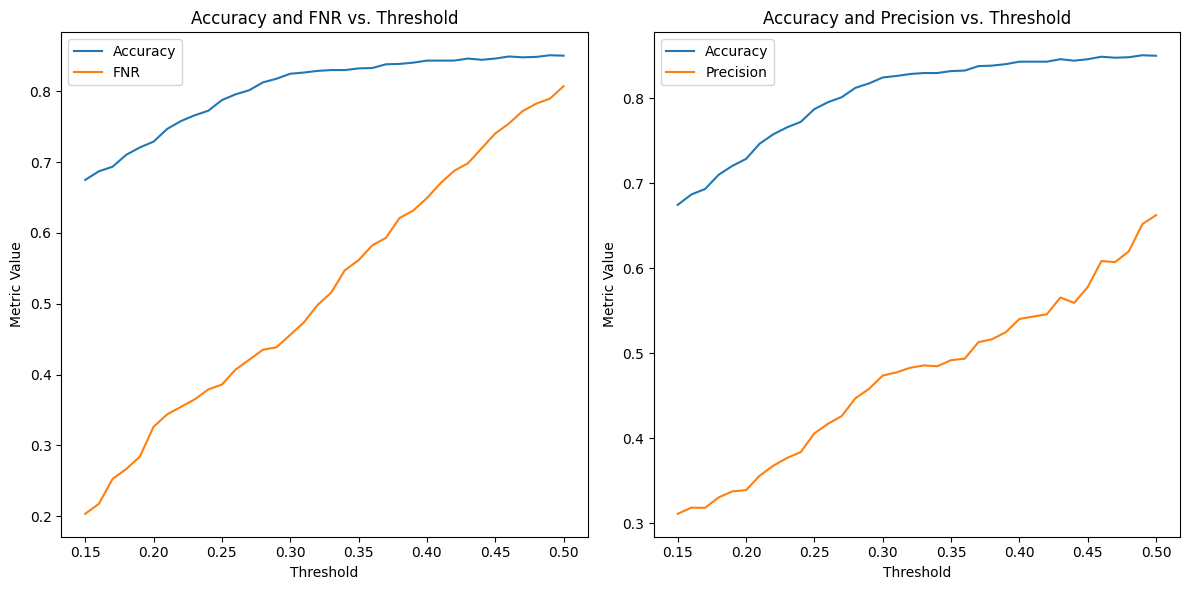

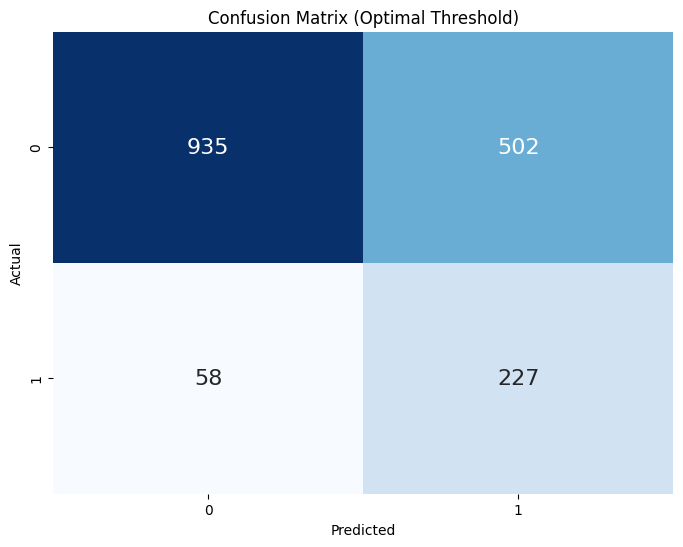

Optimal Threshold: 0.15
Accuracy: 0.6748
Misclassification Rate: 0.3252
True Positive Rate (Recall): 0.7965
False Positive Rate: 0.3493
False Negative Rate: 0.2035
True Negative Rate: 0.6507
Precision: 0.3114
Recall: 0.7965
AUC: 0.7929
Optimal Grid Search Parameters: {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
# Replace 'your_dataset.csv' with your actual dataset file
# df = pd.read_csv('your_dataset.csv')

# Drop the ID column temporarily for model training
X = df.drop(columns=['Airbnb Host ID', 'host_is_superhost_in_period'])
y = df['host_is_superhost_in_period']

# Convert binary columns to numeric
X['Instantbook Enabled'] = X['Instantbook Enabled'].astype(int)

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 25, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 4, 6]
}

# Define the scoring metric for grid search
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Initialize lists to store metrics at different thresholds
thresholds = [i / 100 for i in range(15, 51)]
accuracies = []
fnrs = []
precisions = []

# Loop through different thresholds
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate metrics
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

    # Append to lists
    accuracies.append(accuracy)
    fnrs.append(fnr)
    precisions.append(precision)

# Plot graphs
plt.figure(figsize=(12, 6))

# Accuracy and FNR graph
plt.subplot(1, 2, 1)
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, fnrs, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and FNR vs. Threshold')
plt.legend()

# Accuracy and Precision graph
plt.subplot(1, 2, 2)
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and Precision vs. Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Get the optimal threshold
optimal_threshold_index = fnrs.index(min(fnrs))
optimal_threshold = thresholds[optimal_threshold_index]

# Adjust the probability threshold to the optimal value
y_pred_optimal = (y_prob > optimal_threshold).astype(int)

# Draw colorful confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Optimal Threshold)')
plt.show()

# Print metrics for the best model
print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'Accuracy: {accuracies[optimal_threshold_index]:.4f}')
print(f'Misclassification Rate: {1 - accuracies[optimal_threshold_index]:.4f}')
print(f'True Positive Rate (Recall): {1 - fnrs[optimal_threshold_index]:.4f}')
print(f'False Positive Rate: {cm[0, 1] / (cm[0, 0] + cm[0, 1]):.4f}')
print(f'False Negative Rate: {fnrs[optimal_threshold_index]:.4f}')
print(f'True Negative Rate: {cm[0, 0] / (cm[0, 0] + cm[0, 1]):.4f}')
print(f'Precision: {precisions[optimal_threshold_index]:.4f}')
print(f'Recall: {1 - fnrs[optimal_threshold_index]:.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')
print(f'Optimal Grid Search Parameters: {best_params}')

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load your new dataset, replace 'new_dataset.csv' with your actual file
ndf = pd.read_csv('aggregated_data_New_York.csv')
columns_to_drop = ['superhost_period_all', 'prev_host_is_superhost_in_period', 'superhost_change_lose_superhost',
                   'prev_Instantbook Enabled', 'tract_total_pop', 'tract_white_perc', 'tract_black_perc',
                   'tract_asian_perc', 'tract_housing_units', 'zip_total_population',
                   'zip_hispanic_or_latino_anyrace', 'zip_hispanic_or_latino_anyrace_percent', 'zip_white_nothispanic',
                   'zip_white_nothispanic_percent', 'zip_black_nothispanic', 'zip_black_nothispanic_percent',
                   'zip_asian_nothispanic', 'zip_asian_nothispanic_percent', 'prev_year_superhosts',
                   'booked_days_period_city', 'revenue_period_city']



new_df = ndf.drop(columns=columns_to_drop)


# Assuming 'Airbnb Host ID' is the ID column, and other columns are the features
# Drop unnecessary columns for model prediction
X_new = new_df.drop(columns=['Airbnb Host ID'])

# Convert binary columns to numeric if needed
X_new['Instantbook Enabled'] = X_new['Instantbook Enabled'].astype(int)

# Check if all features used for training are present in the new dataset
missing_features = set(X.columns) - set(X_new.columns)
if missing_features:
    raise ValueError(f"Features missing in the new dataset: {missing_features}")

# Define the RandomForest model with the optimal parameters
best_model = RandomForestClassifier(random_state=42, max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=100)

# Fit the model on your new dataset
best_model.fit(X, y)

# Check if 'Churn' column already exists in the new dataset
if 'Churn' in new_df.columns:
    raise ValueError("'Churn' column already exists in the new dataset. Please choose a different name.")

# Predict probabilities for the new dataset
y_prob_new = best_model.predict_proba(X_new)[:, 1]

# Create a new variable 'Churn' based on the predicted probabilities
new_df['Churn'] = (y_prob_new > optimal_threshold).astype(int)

# Get the top 5% of Airbnb Host IDs with max probability
top_5_percent = new_df.sort_values(by='Churn', ascending=False).head(int(0.05 * len(new_df)))

# Print the top 5% Airbnb Host IDs with calculated probabilities
print("Top 5% of Airbnb Host IDs with Max Probability:")
print(top_5_percent[['Airbnb Host ID', 'Churn']])

# Print calculated probabilities for the top 5% in descending order
top_5_probabilities = top_5_percent[['Airbnb Host ID', 'Churn']].sort_values(by='Churn', ascending=False)
print("\nCalculated Probabilities for the Top 5%:")
print(top_5_probabilities)

Top 5% of Airbnb Host IDs with Max Probability:
      Airbnb Host ID  Churn  Predicted_Probability
0               2787      1               0.225516
2143        22304153      1               0.213996
2132        22188911      1               0.509744
2133        22189723      1               0.150532
2135        22220783      1               0.158250
...              ...    ...                    ...
2396        28316637      1               0.392988
2397        28345063      1               0.584286
2398        28357796      1               0.584060
2401        28477455      1               0.259324
2404        28720484      1               0.554598

[188 rows x 3 columns]


In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load your new dataset, replace 'new_dataset.csv' with your actual file
ndf = pd.read_csv('aggregated_data_New_York.csv')
columns_to_drop = ['superhost_period_all', 'prev_host_is_superhost_in_period', 'superhost_change_lose_superhost',
                   'prev_Instantbook Enabled', 'tract_total_pop', 'tract_white_perc', 'tract_black_perc',
                   'tract_asian_perc', 'tract_housing_units', 'zip_total_population',
                   'zip_hispanic_or_latino_anyrace', 'zip_hispanic_or_latino_anyrace_percent', 'zip_white_nothispanic',
                   'zip_white_nothispanic_percent', 'zip_black_nothispanic', 'zip_black_nothispanic_percent',
                   'zip_asian_nothispanic', 'zip_asian_nothispanic_percent', 'prev_year_superhosts',
                   'booked_days_period_city', 'revenue_period_city']



new_df = ndf.drop(columns=columns_to_drop)


# Assuming 'Airbnb Host ID' is the ID column, and other columns are the features
# Drop unnecessary columns for model prediction
X_new = new_df.drop(columns=['Airbnb Host ID'])

# Convert binary columns to numeric
X_new['Instantbook Enabled'] = X_new['Instantbook Enabled'].astype(int)

# Define the Random Forest model with optimal parameters
optimal_model = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=3,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

# Train the model with the entire original dataset
optimal_model.fit(X, y)

# Predict for the new dataset
new_df['Churn_Prob'] = optimal_model.predict_proba(X_new)[:, 1]

# Identify the top 5% of host IDs
top_5_percent = new_df.sort_values(by='Churn_Prob', ascending=False).head(int(0.01 * len(new_df)))

# Display the top 5% of host IDs with calculated probabilities
print("Top 1% of Host IDs with Max Probability:")
print(top_5_percent[['Airbnb Host ID', 'Churn_Prob']])

Top 1% of Host IDs with Max Probability:
      Airbnb Host ID  Churn_Prob
3535        99246264    0.816460
3735       126918682    0.756405
3747       129106970    0.749849
3167        63383282    0.740976
2802        44437046    0.739147
3591       104132988    0.739060
969          4021487    0.738532
1951        18053985    0.737333
1280         6847312    0.733536
3013        51937277    0.733095
3647       112198878    0.724683
3552       101279661    0.711500
3509        97022024    0.706357
2881        47595754    0.697781
3674       117263759    0.696246
860          3320288    0.683139
3596       105117303    0.682341
2344        26606802    0.681329
274           644941    0.680032
3095        58188847    0.675421
1538         9860275    0.675258
3644       111310847    0.665964
1846        15613411    0.662917
3623       107800052    0.662357
3671       116976293    0.661893
3502        96159925    0.656500
3760       133785513    0.654468
3625       108042864    0.654385
37

In [12]:
new_data = pd.read_csv('aggregated_data_New_York.csv')

columns_to_drop = ['superhost_period_all', 'prev_host_is_superhost_in_period', 'superhost_change_lose_superhost',
                   'prev_Instantbook Enabled', 'tract_total_pop', 'tract_white_perc', 'tract_black_perc',
                   'tract_asian_perc', 'tract_housing_units', 'zip_total_population',
                   'zip_hispanic_or_latino_anyrace', 'zip_hispanic_or_latino_anyrace_percent', 'zip_white_nothispanic',
                   'zip_white_nothispanic_percent', 'zip_black_nothispanic', 'zip_black_nothispanic_percent',
                   'zip_asian_nothispanic', 'zip_asian_nothispanic_percent', 'prev_year_superhosts',
                   'booked_days_period_city', 'revenue_period_city']



new_data = new_data.drop(columns=columns_to_drop)




# Drop the ID column temporarily for prediction
X_new = new_data.drop(columns=['Airbnb Host ID'])

# Convert binary columns to numeric
X_new['Instantbook Enabled'] = X_new['Instantbook Enabled'].astype(int)

# Make predictions on the new dataset
y_prob_new = best_model.predict_proba(X_new)[:, 1]

# Create a new column 'churn_prob' in the new_data DataFrame
new_data['churn_prob'] = y_prob_new

# Get the top 1% of Airbnb Host IDs with max probabilities
top_1_percent = new_data.sort_values(by='churn_prob', ascending=False).head(int(0.01 * len(new_data)))

# Display the top 1% of Airbnb Host IDs with max probabilities
print("Top 1% of Airbnb Host IDs with Max Probabilities:")
print(top_1_percent[['Airbnb Host ID', 'churn_prob']])

Top 1% of Airbnb Host IDs with Max Probabilities:
      Airbnb Host ID  churn_prob
441          1314045    0.970245
3596       105117303    0.863864
1362         7706697    0.855675
998          4204562    0.855645
2018        19962052    0.851194
3152        62328018    0.812814
637          2092314    0.772158
875          3407346    0.766331
958          3931950    0.761759
2326        26228378    0.740260
2534        33163646    0.736711
1358         7678072    0.716573
2983        50573299    0.711565
3167        63383282    0.710371
3463        93148942    0.701796
770          2689908    0.692237
1846        15613411    0.671532
3516        97513787    0.657037
1951        18053985    0.656661
2164        22652051    0.647604
3509        97022024    0.641047
1749        13161042    0.637497
2317        25846948    0.624372
3020        52092698    0.623002
2584        34915405    0.622506
2881        47595754    0.620927
2657        37561828    0.619772
1477         9111709    0.

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load your new dataset, replace 'new_dataset.csv' with your actual file
ndf = pd.read_csv('aggregated_data_New_York.csv')
columns_to_drop = ['superhost_period_all', 'prev_host_is_superhost_in_period', 'superhost_change_lose_superhost',
                   'prev_Instantbook Enabled', 'tract_total_pop', 'tract_white_perc', 'tract_black_perc',
                   'tract_asian_perc', 'tract_housing_units', 'zip_total_population',
                   'zip_hispanic_or_latino_anyrace', 'zip_hispanic_or_latino_anyrace_percent', 'zip_white_nothispanic',
                   'zip_white_nothispanic_percent', 'zip_black_nothispanic', 'zip_black_nothispanic_percent',
                   'zip_asian_nothispanic', 'zip_asian_nothispanic_percent', 'prev_year_superhosts',
                   'booked_days_period_city', 'revenue_period_city']



new_df = ndf.drop(columns=columns_to_drop)




X_new = new_df.drop(columns=['Airbnb Host ID'])

# Convert binary columns to numeric
X_new['Instantbook Enabled'] = X_new['Instantbook Enabled'].astype(int)

# Define the Random Forest model with optimal parameters
optimal_params = {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
model = RandomForestClassifier(random_state=42, **optimal_params)

# Train the model on the entire original dataset
model.fit(X, y)

# Make predictions on the new dataset
y_prob_new = model.predict_proba(X_new)[:, 1]

# Assign binary values based on the threshold probability
threshold = 0.15
new_df['Churn'] = (y_prob_new > threshold).astype(int)

# Get the top 5% of Airbnb Host IDs with max probabilities
top_5_percent = new_df.sort_values(by='Churn', ascending=False).head(int(0.05 * len(new_df)))

# Display the distribution of host IDs in different classes of the predicted Churn variable
class_distribution = new_df['Churn'].value_counts()
print("Distribution of host IDs in different classes of the predicted Churn variable:")
print(class_distribution)

# Display the top 5% of Airbnb Host IDs with max probabilities
print("Top 5% of Airbnb Host IDs with Max Probabilities:")
print(top_5_percent[['Airbnb Host ID', 'Churn', 'Predicted Probability']])

Distribution of host IDs in different classes of the predicted Churn variable:
1    1934
0    1830
Name: Churn, dtype: int64
Top 5% of Airbnb Host IDs with Max Probabilities:


KeyError: ignored

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load your new dataset, replace 'new_dataset.csv' with your actual file
ndf = pd.read_csv('aggregated_data_New_York.csv')
columns_to_drop = ['superhost_period_all', 'prev_host_is_superhost_in_period', 'superhost_change_lose_superhost',
                   'prev_Instantbook Enabled', 'tract_total_pop', 'tract_white_perc', 'tract_black_perc',
                   'tract_asian_perc', 'tract_housing_units', 'zip_total_population',
                   'zip_hispanic_or_latino_anyrace', 'zip_hispanic_or_latino_anyrace_percent', 'zip_white_nothispanic',
                   'zip_white_nothispanic_percent', 'zip_black_nothispanic', 'zip_black_nothispanic_percent',
                   'zip_asian_nothispanic', 'zip_asian_nothispanic_percent', 'prev_year_superhosts',
                   'booked_days_period_city', 'revenue_period_city']




X_new = ndf.drop(columns=['Airbnb Host ID'])

# Convert binary columns to numeric
X_new['Instantbook Enabled'] = X_new['Instantbook Enabled'].astype(int)

# Define the Random Forest model with optimal parameters
optimal_params = {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
model = RandomForestClassifier(random_state=42, **optimal_params)

# Train the model on the entire original dataset
model.fit(X, y)

# Make predictions on the new dataset
y_prob_new = model.predict_proba(X_new)[:, 1]

# Assign binary values based on the threshold probability
threshold = 0.15
new_data['Churn'] = (y_prob_new > threshold).astype(int)

# Get the top 5% of Airbnb Host IDs with max probabilities
top_5_percent = new_data.sort_values(by='Churn', ascending=False).head(int(0.05 * len(new_data)))

# Display the distribution of host IDs in different classes of the predicted Churn variable
class_distribution = new_data['Churn'].value_counts()
print("Distribution of host IDs in different classes of the predicted Churn variable:")
print(class_distribution)

# Display the top 5% of Airbnb Host IDs with max probabilities
print("Top 5% of Airbnb Host IDs with Max Probabilities:")
print(top_5_percent[['Airbnb Host ID', 'Churn', 'Predicted Probability']])

ValueError: ignored